In [1]:
from tectosaur2.nb_config import setup
setup()

In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import refine_surfaces, gauss_rule
from tectosaur2.mesh import pts_grid
from tectosaur2.elastic2d import ElasticU, ElasticT

nobs = 50
V = 2
zoomx = [-V, V]
zoomy = [-V, V]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

t = sp.var("t")
(fault,) = refine_surfaces([(t, t, t)], gauss_rule(12))


In [4]:
shear_modulus = 1.0  # 3e10
poisson_ratio = 0.25


In [5]:
Tstar = ElasticT(shear_modulus, poisson_ratio)
T = Tstar.direct(obs_pts, fault)

In [6]:
slip = np.full((fault.n_pts, 2), 1.0 / np.sqrt(2))


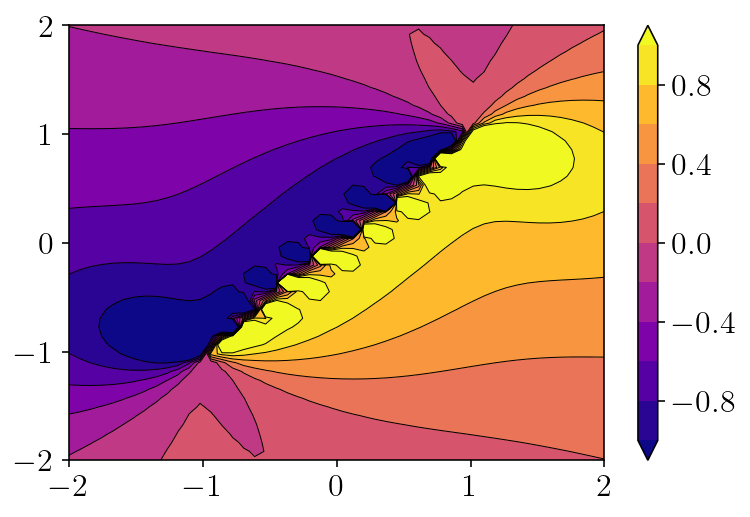

In [8]:
disp = np.sum(T * slip[None, None, :, :], axis=(2, 3))
v2d = disp.reshape((nobs, nobs, 2))[:, :, 0]
levels = np.linspace(-1, 1, 11)
cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
plt.contour(
    xs,
    ys,
    v2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()


In [9]:
Ustar = ElasticU(shear_modulus, poisson_ratio)
S = Ustar.direct(obs_pts, fault)

In [11]:
src=fault
kappa = 3 - 4 * poisson_ratio
p = 20
z = obs_pts[:, None, 0] + obs_pts[:, None, 1] * 1j
w = src.pts[None, :, 0] + src.pts[None, :, 1] * 1j
z0 = z * 1.2
S3 = np.empty((z0.shape[0], 2, src.n_pts, 2))
for d_src in range(2):
    tw = (d_src == 0) + (d_src == 1) * 1j
    f1 = np.zeros((z.shape[0], w.shape[1]), dtype=np.complex128)
    f3 = np.zeros((z.shape[0], w.shape[1]), dtype=np.complex128)
    for m in range(p):
        ratio = ((z-z0) / (w-z0))
        if m == 0:
            T = (z-z0) ** m * np.log(w - z0)
        else:
            T = (-1.0 / m) * ratio ** m
        f1 += T * tw + np.conjugate(T) * tw
        f3 += -(z - w) * np.conjugate(tw * ratio ** m / (w - z0))

    V = (
        (1.0 / (4 * np.pi * shear_modulus * (1 + kappa))) * (-kappa * f1 + f3)
    ) + Ustar.disp_C1 * 0.5 * tw
    S3[:, 0, :, d_src] = np.real(V)
    S3[:, 1, :, d_src] = np.imag(V)

In [12]:
S2 = np.empty((obs_pts.shape[0], src.n_pts, 2), dtype=np.complex128)
kappa = 3 - 4 * poisson_ratio
z0 = obs_pts[:, None, 0] + obs_pts[:, None, 1] * 1j
z = src.pts[None, :, 0] + src.pts[None, :, 1] * 1j
for d_src in range(2):
    P = (d_src == 0) + (d_src == 1) * 1j
    t1 = -kappa * P * (np.log(z0 - z) + np.conjugate(np.log(z0 - z)))
    t2 = np.conjugate(P) * ((z0 - z) / (np.conjugate(z0 - z)))
    S2[:, :, d_src] = (1.0 / (4 * np.pi * shear_modulus * (1 + kappa)) * (t1 + t2)) + Ustar.disp_C1 * P * 0.5


In [13]:
np.max(np.abs(S3[25,:,:,:] - S[25,:,:,:]))

3.576999807464176e-15

In [16]:
S2[25, 0, 0], S2[25,0,1]


((-0.012288188880446207-0.026525626355736374j),
 (-0.026525626355736374-0.012492906104262819j))

In [17]:
S[25,:,0,0]

array([-0.01228819, -0.02652563])

In [20]:
S2 = np.empty((obs_pts.shape[0], src.n_pts, 2), dtype=np.complex128)
kappa = 3 - 4 * poisson_ratio
z0 = obs_pts[:, None, 0] + obs_pts[:, None, 1] * 1j
z = src.pts[None, :, 0] + src.pts[None, :, 1] * 1j
for d_src in range(2):
    P = (d_src == 0) + (d_src == 1) * 1j
    t1 = -kappa * P * (np.log(z0 - z) + np.conjugate(np.log(z0 - z)))
    t2 = np.conjugate(P) * ((z0 - z) / (np.conjugate(z0 - z)))
    S2[:, :, d_src] = 1.0 / (4 * np.pi * shear_modulus * (1 + kappa)) * (t1 + t2) + disp_C1 * P * 0.5


In [21]:
S2[0, 0, 0], S[0, :, 0, 0]


((-0.01218543426511473+0.026525823848649224j), array([0.06523708, 0.02652582]))

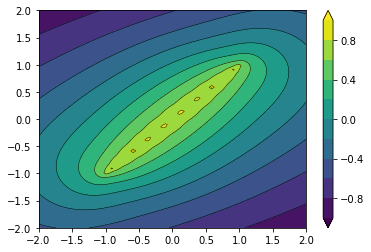

In [123]:
stress = slip
disp = np.sum(S * stress[None, None, :, :], axis=(2, 3))
v2d = disp.reshape((nobs, nobs, 2))[:, :, 0]
levels = np.linspace(-1, 1, 11)
cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
plt.contour(
    xs,
    ys,
    v2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()
